In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from scipy.ndimage import generate_binary_structure
from copy import copy

from z3 import *
from IPython.display import Markdown, display

In [2]:
url='https://www.janestreet.com/puzzles/knight-moves-4-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]

#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n"+"\n".join(y[9:18])))

### September 2021 : Puzzle
Show Solution
A knight was initially located in a square labeled 1. It then proceeded
to make a series of moves, never re-visiting a square, and labeled
the visited squares in order. When the knight was finished, the
labeled squares in each region of connected squares
1
had the same sum.
A short while later, many of the labels were erased. The remaining
labels can be seen above.
Complete the grid by re-entering the missing labels.
The answer to this puzzle is the sum of the
squares
of the largest
label in each row of the completed grid, as in the example.

<img src="https://www.janestreet.com/puzzles/2021-09-01-knight-moves-4.png" width=350>

In [3]:
# Set up the regions and fixed cells

regions=np.array([
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
                 [ 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
                 [ 0, 0, 1, 1, 1, 1, 3, 2, 2, 2],
                 [ 5, 0, 1, 0, 0, 4, 3, 3, 3, 3],
                 [ 5, 0, 0, 0, 4, 4, 4,10,10, 3],
                 [ 5, 6, 6, 7, 4, 9, 9,10,10,11],
                 [ 5,12, 6, 7, 7, 8, 8, 8,10,11],
                 [ 5,12,13, 7,16,16,16,15,15,11],
                 [12,12,13,14,14,14,14,14,15,11]
])

fixed = np.array([
       [12, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0, 5, 0,23, 0],
       [ 0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
       [ 0, 0, 0,14, 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [ 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0,20, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0,33, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0, 0, 0, 0,28]
])

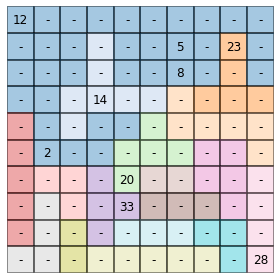

Solution is : 3,210
[12, 23, 8, 14, 0, 2, 20, 33, 0, 28]
[144, 529, 64, 196, 0, 4, 400, 1089, 0, 784]


In [4]:
# print in a nice format and calc the answer

def output(regions,fixed):
    fig,ax = plt.subplots(1,1,figsize=(4,4))    
    x = np.array((fixed).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax =sns.heatmap(regions,annot=x,cbar=False,cmap='tab20',fmt="",
                    linewidths=1,linecolor="k",annot_kws={"size":12,"color":"k"},alpha=.4,)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    print("Solution is : {:,.0f}".format(sum([max(fixed[i,:])**2 for i in range(fixed.shape[1])])))
    print([max(fixed[i,:]) for i in range(fixed.shape[1])])
    print([max(fixed[i,:])**2 for i in range(fixed.shape[1])])
    
output(regions,fixed)

In [5]:
# The trick is to notice there are 17 regions which really limits the number of valid chain lengths. 
# You can't get to the large(chain  > 67) totals with 2 numbers and the large region already adds up to 51
# as 13 & 11 have to be in that region,6\ which excludes shorter chain lengths. 33 is one of the given numbrs
# which implies the chain length is 50 or 51

tot =  lambda x: x*(1+x)/2
print("Possible chain lengths where the total is divisible by 17 and the region totals :\n ",[(i,int(tot(i)/17)) for i in range(33,101) if tot(i) % 17 ==0 ])
print("Sum of large region given 11 & 13 must be in :" ,12+5+8+2+11+13)
print("Max given there are 2 regions with only 2 cells :" ,51+48,67+64,68+65)

Possible chain lengths where the total is divisible by 17 and the region totals :
  [(33, 33), (34, 35), (50, 75), (51, 78), (67, 134), (68, 138), (84, 210), (85, 215)]
Sum of large region given 11 & 13 must be in : 51
Max given there are 2 regions with only 2 cells : 99 131 133


In [6]:
def moves(i,j,N):
    moves=[(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    return [(i+x,j+y) for x,y in moves if i+x >=0 and i+x<N and j+y>=0 and j+y<N ]

In [7]:
def fill(regions,fixed,fix_y):
    start = time.time()
    N= regions.shape[0]
    R =np.max(regions)
    
    X = np.array(IntVector('x', N*N),dtype=object).reshape((N,N))
    Y = fix_y*(1+fix_y)/2/(R+1)
    print("Total for each region : ",Y)
            
    s = Tactic('default').solver()
    if R ==16:
        s+= Or(And(X[1,2]==11,X[2,1]==13),And(X[1,2]==13,X[2,1]==11))
        s+= Or(And(X[7,8]==27,X[8,7]==29),And(X[7,8]==29,X[8,7]==27))
      
    s += [And(e >= 0  ,e <= fix_y) for (i,j),e in np.ndenumerate(X)]
    s += [X[i,j] == int(e) for (i,j),e in np.ndenumerate(fixed) if e !=0]
    s += [Sum([e for (i,j),e in np.ndenumerate(X) if regions[i,j]==n])==Y for n in range(R+1)]
    s += [Or(e==0,e==1,PbEq([(X[k,l]==e-1,1) for k,l in moves(i,j,N)],1)) for (i,j),e in np.ndenumerate(X)] 
    s += [PbEq([(e==n,1) for (i,j),e in np.ndenumerate(X)],1) for n in range(1,fix_y+1)]    
    
    if s.check() == sat:
        m = s.model()
        eval = np.vectorize(lambda x:m.evaluate(x).as_long())
        result =  eval(X)
        output(regions,result)
        print("Took {:.4f} seconds".format(time.time()-start))
        return result
    else:
        print("{} failed in {:.4f} seconds".format(fix_y,time.time()-start))       

Total for each region :  75.0


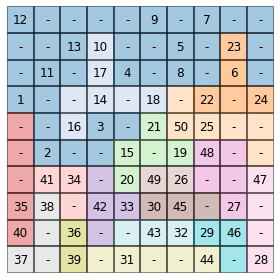

Solution is : 14,820
[12, 23, 17, 24, 50, 48, 49, 45, 46, 44]
[144, 529, 289, 576, 2500, 2304, 2401, 2025, 2116, 1936]
Took 57.2586 seconds


In [8]:
out =fill(regions,fixed,50)

In [15]:
url='https://www.janestreet.com/puzzles/knight-moves-4-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]

#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n"+"\n".join(y[10:18])))

### September 2021 : Solution
The above image shows the reconstructed path of the knight. The move
count of 50, and region sum of 75, can be deduced by the three
observations:
the sum of all numbers must be a triangular number,
the sum of all numbers must be divisible by 17, and
the regions of size 2 must have an odd sum by parity arguments of
knight moves.
Once this is known the path of the knight can be deduced by hand or
with the aid of a program (we saw both solution methods). The sum of
the squares of the maxima of each row comes to
14820
.
Congrats to this month’s solvers who successfully deduced the
knight’s path!

<img src="https://www.janestreet.com/puzzles/2021-09-01-knight-moves-4-solution.png" width=350>

In [10]:
regions1 =np.array([[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0],
                   [1, 1, 1, 1, 0],
                   [1, 2, 2, 0, 0]])

fixed1 =np.array([[1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 4],
                 [0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0],
                 [0, 6, 0, 0, 0]])

soln1 =np.array([[1, 0, 3, 0, 0],
                 [0, 0, 0, 0, 4],
                 [0, 2, 7, 0, 0],
                 [8, 0, 0, 5, 0],
                 [0, 6, 9, 0, 0]])

Total for each region :  15.0


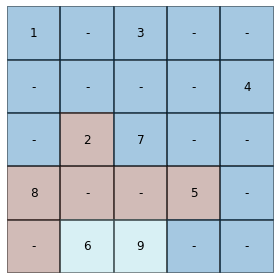

Solution is : 219
[3, 4, 7, 8, 9]
[9, 16, 49, 64, 81]
Took 0.1451 seconds


In [11]:
out2 =fill(regions1,fixed1,9)